<a href="https://colab.research.google.com/github/CirilJapeth/Machine-Learning/blob/main/DT%5BTitanic%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import re
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

train = pd.read_csv('tested.csv')
test = pd.read_csv('tested.csv')

PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [ ]:
original_train = train.copy()

full_data = [train, test]

train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
   
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    

    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

In [ ]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [ ]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,2,0,0,2,0,1,1,1
1,1,3,0,2,0,0,0,0,2,0,3
2,0,2,1,3,0,1,2,0,1,1,1


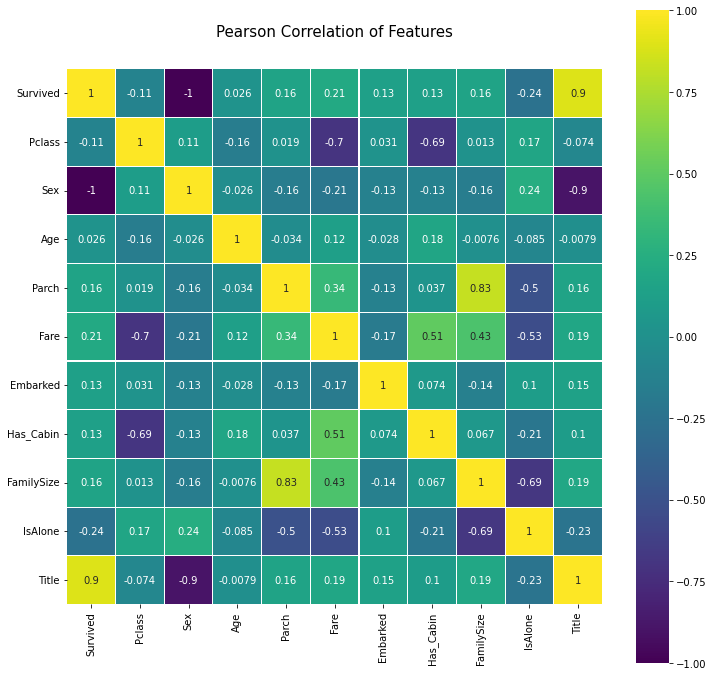

In [ ]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [ ]:
train[['Title', 'Survived']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

Survived          
           mean count sum
Title                    
1      0.000000   240   0
2      0.000000    21   0
3      1.000000    72  72
4      1.000000    79  79
5      0.166667     6   1

In [ ]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).agg(['mean', 'count', 'sum'])

Survived           
        mean count  sum
Sex                    
0        1.0   152  152
1        0.0   266    0

In [ ]:
title_and_sex = original_train.copy()[['Name', 'Sex']]

title_and_sex['Title'] = title_and_sex['Name'].apply(get_title)

title_and_sex['Sex'] = title_and_sex['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

title_and_sex[['Title', 'Sex']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])


Sex           
       mean count  sum
Title                 
Col     1.0     2    2
Dona    0.0     1    0
Dr      1.0     1    1
Master  1.0    21   21
Miss    0.0    78    0
Mr      1.0   240  240
Mrs     0.0    72    0
Ms      0.0     1    0
Rev     1.0     2    2

In [ ]:
def get_gini_impurity(survived_count, total_count):
    survival_prob = survived_count/total_count
    not_survival_prob = (1 - survival_prob)
    random_observation_survived_prob = survival_prob
    random_observation_not_survived_prob = (1 - random_observation_survived_prob)
    mislabelling_survided_prob = not_survival_prob * random_observation_survived_prob
    mislabelling_not_survided_prob = survival_prob * random_observation_not_survived_prob
    gini_impurity = mislabelling_survided_prob + mislabelling_not_survided_prob
    return gini_impurity

In [ ]:
gini_impurity_starting_node = get_gini_impurity(342, 891)
gini_impurity_starting_node

0.47301295786144265

In [ ]:
gini_impurity_men = get_gini_impurity(109, 577)
gini_impurity_men

0.3064437162277843

In [ ]:
gini_impurity_women = get_gini_impurity(233, 314)
gini_impurity_women

0.3828350034484158

In [ ]:
men_weight = 577/891
women_weight = 314/891
weighted_gini_impurity_sex_split = (gini_impurity_men * men_weight) + (gini_impurity_women * women_weight)

sex_gini_decrease = weighted_gini_impurity_sex_split - gini_impurity_starting_node
sex_gini_decrease

-0.13964795747285214

In [ ]:
gini_impurity_title_1 = get_gini_impurity(81, 517)
gini_impurity_title_1

0.26425329886377663

In [ ]:
gini_impurity_title_others = get_gini_impurity(261, 374)
gini_impurity_title_others

0.42170207898424317

In [ ]:
title_1_weight = 517/891
title_others_weight = 374/891
weighted_gini_impurity_title_split = (gini_impurity_title_1 * title_1_weight) + (gini_impurity_title_others * title_others_weight)

title_gini_decrease = weighted_gini_impurity_title_split - gini_impurity_starting_node
title_gini_decrease

-0.14267004758907514

In [ ]:
cv = KFold(n_splits=10)
accuracies = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)

for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    for train_fold, valid_fold in cv.split(train):
        f_train = train.loc[train_fold] 
        f_valid = train.loc[valid_fold] 

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"]) 
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"])
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    print("Accuracy per fold: ", fold_accuracy, "\n")
    print("Average accuracy: ", avg)
    print("\n")
    
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

Accuracy per fold:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 

Average accuracy:  1.0


Accuracy per fold:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 

Average accuracy:  1.0


Accuracy per fold:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 

Average accuracy:  1.0


Accuracy per fold:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 

Average accuracy:  1.0


Accuracy per fold:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 

Average accuracy:  1.0


Accuracy per fold:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 

Average accuracy:  1.0


Accuracy per fold:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 

Average accuracy:  1.0


Accuracy per fold:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 

Average accuracy:  1.0


Accuracy per fold:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 

Average accuracy:  1.0


Accuracy per fold:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 

Average accuracy:  1.0


Accuracy per fold:  

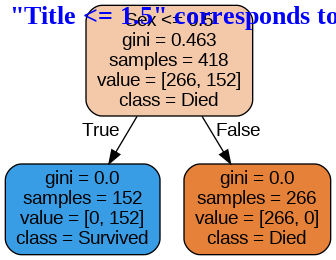

In [ ]:
y_train = train['Survived']
x_train = train.drop('Survived', axis=1).values
x_test = train.drop('Survived', axis=1).values

decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(x_train, y_train)

y_pred = decision_tree.predict(x_test)
submission = pd.DataFrame({
        "PassengerId": PassengerId,
        "Survived": y_pred
    })
submission.to_csv('submission.csv', index=False)

with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 3,
                              impurity = True,
                              feature_names = list(train.drop(['Survived'], axis=1)),
                              class_names = ['Died', 'Survived'],
                              rounded = True,
                              filled= True )
        
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', 26)
draw.text((10, 0),
          '"Title <= 1.5" corresponds to "Mr." title',
          (0,0,255),
          font=font) 
img.save('sample-out.png')
PImage("sample-out.png")

In [ ]:
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
print('Accuracy :',acc_decision_tree,'%')

Accuracy : 100.0 %
